In [ ]:
import os
import shutil
import glob
from operator import ne
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt   
%matplotlib inline

from google.colab import drive
from google.colab import files
from google.colab import files

drive.mount('/content/drive')
# uploaded = files.upload()
# for fn in uploaded.keys():
#     print('User uploaded file "{name}" with length {length} bytes'.format(
#         name=fn, length=len(uploaded[fn])))

Mounted at /content/drive


In [ ]:
!pip install -r requirements.txt

     |████████████████████████████████| 1.9 MB 20.4 MB/s 
     |████████████████████████████████| 1.4 MB 46.1 MB/s 
     |████████████████████████████████| 64 kB 1.5 MB/s 
     |████████████████████████████████| 190 kB 80.5 MB/s 
     |████████████████████████████████| 3.6 MB 56.4 MB/s 
     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
     |████████████████████████████████| 138 kB 76.9 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 97 kB 8.2 MB/s 
     |████████████████████████████████| 843 kB 57.7 MB/s 
     |████████████████████████████████| 69 kB 8.2 MB/s 
     |████████████████████████████████| 42 kB 1.0 MB/s 
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6084 sha256=0e72652d110566144c40c9aabeca7b469533bc19c4ffe93b2658c05440e5e514
  Stored in directory: /root/.cache/pip/wheels/64/80/6e/caa3e16deb0267c3cbfd36862058a724144e19fdb9eb03af0f
Succes

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.preprocessing import image   # for preprocessing the images
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD


In [ ]:
validation_path = '/content/drive/MyDrive/core simulateur/Video validations'
video_path = '/content/drive/MyDrive/core simulateur'
kss_path = '/content/drive/MyDrive/DDDS/KSS'
root_path = '/content/drive/MyDrive/DDDS'
validation_df_path= '/content/drive/MyDrive/DDDS/dataframes'

In [ ]:
my_file = open(f'{kss_path}/kss_files.txt', 'r')
content = my_file.read()
kss_files = content.split("\n")[:-1]
my_file.close()
kss_list = [kss[:-5].replace(' ', '_') for kss in kss_files]

## converting videos to frame

In [ ]:
fps = 1
os.chdir(video_path)

for file_name in kss_files[2:3]: #kss_files[8:]: # first and 2nd videos have benn already coverted.
    file_ = file_name.replace(" ", "\\ " )
    print(file_)
    frame_name = file_[:-5].replace("\\ ", "_" ) #removing xlsx
    print(frame_name)
    os.mkdir(f"/content/drive/MyDrive/DDDS/dataset/frames/{frame_name}")
    frame_path = f'/content/drive/MyDrive/DDDS/dataset/frames/{frame_name}'
    print(f'folder', frame_path)
    # command = f'ffmpeg -i {file_} -c:v libx264 -crf 19 -strict experimental /content/drive/MyDrive/DDDS/videos/{file_[:-4]}.mp4'
    command = f'ffmpeg -i {file_[:-5]}.flv -vf fps={fps} {frame_path}/{frame_name}_frame-%05d.jpg'
    print(command)
    os.system(command)

2021-10-28\ 15-04-13\ 1c3.xlsx
2021-10-28_15-04-13_1c3
folder /content/drive/MyDrive/DDDS/dataset/frames/2021-10-28_15-04-13_1c3
ffmpeg -i 2021-10-28\ 15-04-13\ 1c3.flv -vf fps=1 /content/drive/MyDrive/DDDS/dataset/frames/2021-10-28_15-04-13_1c3/2021-10-28_15-04-13_1c3_frame-%05d.jpg


## face detection

In [ ]:
def bounding_box_check(faces, x, y):
    # check the center
    for face in faces:
        bounding_box = face['box']
        if (bounding_box[1] < 0):
            bounding_box[1] = 0
        if (bounding_box[0] < 0):
            bounding_box[0] = 0
        if (bounding_box[0] - 100 > x
                or bounding_box[0] + bounding_box[2] + 100 < x):
            print('change person from')
            print(bounding_box)
            print('to')
            continue
        if (bounding_box[1] - 100 > y
                or bounding_box[1] + bounding_box[3] + 100 < y):
            print('change person from')
            print(bounding_box)
            print('to')
            continue
        return bounding_box

def face_detect(file, detector, frame_path, x_pos, y_pos):
    name = file.replace('.jpg', '').split('-')

    x = x_pos
    y = y_pos
    img = cv2.imread('%s%s' % (frame_path, file ))
    faces = detector.detect_faces(img)
    # check if detected faces
    if (len(faces) == 0):
        print('no face detect: ' + file)
        return  #no face
    bounding_box = bounding_box_check(faces, x, y)
    if (bounding_box == None):
        print('face is not related to given coord: ' + file)
        return
    print(file, " ", bounding_box)
    print(file, " ", x, y)
    crop_img = img[bounding_box[1]:bounding_box[1] + bounding_box[3],
                   bounding_box[0]:bounding_box[0] + bounding_box[2]]
    crop_img = cv2.resize(crop_img, (244, 244))
    print(f"saving {file}")
    cv2.imwrite(f'{output_dir}{file}', crop_img)
    # cv2.imwrite('%s/frame_' % output_dir + name[0] + '_' + name[1] + '.jpg',
    #             crop_img)
    

In [ ]:
kss_list = [f[:-4] for f in os.listdir(kss_path) 
             if os.path.isfile(os.path.join(kss_path, f)) and 'kss_' in f][1:]
kss_list.sort()
print(f'The are {len(kss_list)} kss df.')

In [ ]:
root_path = '/content/drive/MyDrive/DDDS/dataset'
os.chdir(root_path)
# proper way would be to assign an exact (x, y) position of the face center.
x = 1100
y = 200


detector = MTCNN()

for file_name in kss_files[2:3]: # 3rd one 2021-11-02 seems to be corrupted.
                                 # check what's wrong with the 2nd one.
    file_ = file_name.replace(" ", "\\ " )
    frame_name = file_[:-5].replace("\\ ", "_" )
    print(frame_name)
    # command = f'unzip frames/{frame_name}.zip -d frames/'
    # os.system(command)
    frame_path = f'/content/drive/MyDrive/DDDS/dataset/frames/{frame_name}/'
    output_dir = f'/content/drive/MyDrive/DDDS/dataset/faces/{frame_name}/'
    face_dir = f'/content/drive/MyDrive/DDDS/dataset/faces/{frame_name}'
    frame_dir = f'/content/drive/MyDrive/DDDS/dataset/frames/{frame_name}'
    print('===============================================================')
    print('detected faces will be stored in ', output_dir)
    print('===============================================================')
    print('')
    print(f'laoding {frame_name} .........................')
    print('')
    print('')
    # grouped_frames = [i for i in os.listdir(frame_path) if os.path.isfile(os.path.join(frame_path, i)) and frame_name in i]
    frame_list = os.listdir(frame_dir)
    frame_list.sort()
    # detect_range = 100
    detect_range = len(frame_list)
    print('number of frames',len(frame_list))
    print('')
    print(f'{detect_range} frames are used for face detection.')
    print('===============================================================')
    print('')
    
    for frame_ in frame_list[:detect_range]:

      if (not os.path.exists('%s%s' % (frame_path, frame_))):
        print('cannot find input: ' + '%s%s' % (frame_path, frame_))
        print('===============================================================')
        print('')
        continue
        
      # if (not os.path.exists('%s%s' % (output_dir, frame_))):
      print('')
      print(f'face detection in {frame_}')
      face_detect(frame_, detector, frame_path, x, y)
      print('===============================================================')
      print('')

    # file_name = kss_list[4:].replace(' ', '_') # removing kss_ form the begining of the file 
    kss_file = f'kss_{file_name[:-5]}'
    print('loading ', kss_file)
    print(' ')
    # frame_list = os.listdir(f'frame_path/{file_name}')
    print(f'for {file_name} there are {len(frame_list)} frames') # frames of a video
    print(' ')

    kss_df = pd.read_csv(f'{kss_path}/{kss_file}.csv')
    print(kss_df.shape)

    image_kss_dic = {'time_points': kss_df.time_points, 
                    'kss_value': kss_df.kss_value, 
                    'frame_id': frame_list}

    image_kss_df = pd.DataFrame.from_dict(image_kss_dic)
    print(image_kss_df.shape)
    print(' ')
    print(' ')

    # face_list = [frame_name for frame_name in face_list if file_name in frame_name]
    face_list = os.listdir(face_dir)
    image_kss_df['face_frame_id']= None
    print('-------------------face-------------------')
    print(f'for {file_name} there are {len(face_list)} faces' )
    print(' ')
    print(' ')
    print(image_kss_df.shape)
    image_kss_df.head()
    for i in range(len(face_list)):
        ind_= int(face_list[i][-9:-4])-1
        if ind_< image_kss_df.shape[0]:
          image_kss_df.iloc[ind_, 3] = face_list[i]
        else:
          print('ind_ exceeded with number', ind_)
          print(face_list[i])
          print(';;;;;;;;;;;;;;;;;;;;;;;;')

    ## saving
    image_kss_df.to_csv(f'{validation_df_path}/image_kss_{frame_name}.csv')
    image_kss_df = pd.DataFrame(None)
    
    # print('Removing', frame_dir)
    # try:
    #     shutil.rmtree(frame_dir)
    # except OSError as e:
    #     print("Error: %s - %s." % (e.filename, e.strerror))
    # print("******************************************************************")
    # print("******************************************************************")


2021-10-28_15-04-13_1c3
detected faces will be stored in  /content/drive/MyDrive/DDDS/dataset/faces/2021-10-28_15-04-13_1c3/

laoding 2021-10-28_15-04-13_1c3 .........................


number of frames 4104

4104 frames are used for face detection.

loading  kss_2021-10-28 15-04-13 1c3
 
for 2021-10-28 15-04-13 1c3.xlsx there are 4104 frames
 
(4104, 3)
(4104, 3)
 
 
-------------------face-------------------
for 2021-10-28 15-04-13 1c3.xlsx there are 4076 faces
 
 
(4104, 4)


## Combining kss with images id

In [ ]:
frame_path = '/content/drive/MyDrive/DDDS/dataset/frames'
face_path = '/content/drive/MyDrive/DDDS/dataset/faces'
validation_df_path = '/content/drive/MyDrive/DDDS/dataframes'
kss_path = '/content/drive/MyDrive/DDDS/KSS'

kss_list = [f[:-4] for f in os.listdir(kss_path) 
             if os.path.isfile(os.path.join(kss_path, f)) and 'kss_' in f][1:]
kss_list.sort()
print(f'There are {len(kss_list)} kss df.')
kss_list

# frame_list = [f[:-4] for f in os.listdir(frame_path) 
#               if os.path.isfile(os.path.join(frame_path, f))]
# frame_list.sort()
# print(f'The are {len(frame_list)} frames')

# face_list = [f[:-4] for f in os.listdir(face_path) 
#              if os.path.isfile(os.path.join(face_path, f))]
# face_list.sort()
# print(f'The are {len(face_list)} face')

There are 18 kss df.


['kss_2021-10-25 10-31-58 c27',
 'kss_2021-10-26 13-32-50 c27',
 'kss_2021-10-28 15-04-13 1c3',
 'kss_2021-11-02 15-23-39 1c3',
 'kss_2021-11-04 11-01-00 eca',
 'kss_2021-11-05 13-59-29 ea9',
 'kss_2021-11-17 10-58-38 e99',
 'kss_2021-11-18 13-21-41 e99',
 'kss_2021-11-19 13-38-33 ece',
 'kss_2021-11-22 11-26-24 ea9',
 'kss_2021-11-24 11-01-03 eca',
 'kss_2021-11-24 15-36-04 e99',
 'kss_2021-11-26 12-34-32 1c3',
 'kss_2021-11-26 15-16-28 ea9',
 'kss_2021-11-29 13-48-17 eca',
 'kss_2021-11-30 16-16-03 ece',
 'kss_2021-12-01 13-20-00 e99',
 'kss_2021-12-07 14-35-11 ea9']

In [ ]:
kss_list = [f for f in os.listdir(validation_df_path) 
              if os.path.isfile(os.path.join(validation_df_path, f)) and 'image_kss' in f]
print(kss_list)

combined_kss_image_df = pd.DataFrame(columns = ['time_points', 'kss_value', 'frame_id', 'face_frame_id', 'video_id'])
print(combined_kss_image_df.head())
for f in kss_list:
    df = pd.read_csv(f'{validation_df_path}/{f}')
    df['video_id'] = f[10:-4]
    print(f'loading {validation_df_path}/{f}')
    df.drop(columns='Unnamed: 0', inplace = True, axis = 1)
    combined_kss_image_df = pd.concat([combined_kss_image_df, df], ignore_index=True)
    
combined_kss_image_df.to_csv(f'{validation_df_path}/combined_kss_image.csv')

['image_kss_2021-12-01_13-20-00_e99.csv', 'image_kss_2021-12-07_14-35-11_ea9.csv', 'image_kss_2021-10-26_13-32-50_c27.csv', 'image_kss_2021-11-04_11-01-00_eca.csv', 'image_kss_2021-11-24_11-01-03_eca.csv', 'image_kss_2021-10-25_10-31-58_c27.csv', 'image_kss_2021-11-24_15-36-04_e99.csv', 'image_kss_2021-11-17_10-58-38_e99.csv', 'image_kss_2021-11-26_15-16-28_ea9.csv', 'image_kss_2021-11-29_13-48-17_eca.csv', 'image_kss_2021-11-30_16-16-03_ece.csv', 'image_kss_2021-11-02_15-23-39_1c3.csv', 'image_kss_2021-11-26_12-34-32_1c3.csv', 'image_kss_2021-11-18_13-21-41_e99.csv', 'image_kss_2021-11-19_13-38-33_ece.csv', 'image_kss_2021-11-22_11-26-24_ea9.csv', 'image_kss_2021-11-05_13-59-29_ea9.csv', 'image_kss_2021-10-28_15-04-13_1c3.csv']
Empty DataFrame
Columns: [time_points, kss_value, frame_id, face_frame_id, video_id]
Index: []
loading /content/drive/MyDrive/DDDS/dataframes/image_kss_2021-12-01_13-20-00_e99.csv
loading /content/drive/MyDrive/DDDS/dataframes/image_kss_2021-12-07_14-35-11_ea9.

## Preparing the dataset

In [ ]:
root_dir = '/content/drive/MyDrive/DDDS/'
os.chdir(root_dir)

df = pd.read_csv(f'{validation_df_path}/combined_kss_image.csv')
dataset_df = df.dropna()
n_cat = dataset_df['kss_value'].unique()
n_cat.sort()
n_cat = [str(int(i)) for i in n_cat]

if not os.path.exists('data'):
  os.mkdir('data')

train_path = os.path.join('data', 'train')
if not os.path.exists(train_path):
  os.mkdir(train_path)
  for cat in n_cat:
    os.mkdir(os.path.join(train_path, cat))

test_path = os.path.join('data', 'test')
if not os.path.exists(test_path):
  os.mkdir(test_path)
  for cat in n_cat:
    os.mkdir(os.path.join(test_path, cat))

validation_path = os.path.join('data', 'validation')
if not os.path.exists(validation_path):
  os.mkdir(validation_path)
  for cat in n_cat:
    os.mkdir(os.path.join(validation_path, cat))

In [ ]:
root_dir = '/content/drive/MyDrive/DDDS/'
os.chdir(root_dir)

face_folder = [f[10:-4] for f in kss_list]
train_list = face_folder[:11]
kss_train_list = kss_list[:11]

val_list = face_folder[11:14]
kss_val_list = kss_list[11:14]

test_list = face_folder[14:]
kss_test_list = kss_list[14:]


image_folders = train_list[1:]
kss_files = kss_train_list[1:]
#print(image_folders)
for kss_file, image_folder in zip(kss_files, image_folders):
  df = pd.read_csv(f'{validation_df_path}/{kss_file}')
  df.drop(columns = ['Unnamed: 0', 'time_points', 'frame_id'], inplace = True, axis = 1)
  df.dropna(inplace = True)
  df['kss_value'] = df['kss_value'].astype(int).astype(str)
  print(df['kss_value'].value_counts())
  print('')
  source_dir = os.path.join('dataset','faces', image_folder)
  print(f'Images will be copied from {source_dir}')
  for index, row in df.iterrows():
      cat = row['kss_value']
      image_name = row['face_frame_id']
      source_ = os.path.join(source_dir, image_name)
      target = os.path.join('data', 'train', str(cat), image_name)
      # print(f'moving {image_name} from {source_} to {target}')
      shutil.copyfile(source_, target)

  print(f'Images were all copied')
  print('')

  print('Removing', source_dir)
  try:
      shutil.rmtree(source_dir)
  except OSError as e:
      print("Error: %s - %s." % (e.filename, e.strerror))
  print("******************************************************************")
  print("******************************************************************")

9    2696
8     593
4     294
5      65
0       1
Name: kss_value, dtype: int64

Images will be copied from dataset/faces/2021-12-07_14-35-11_ea9
Images were all copied

Removing dataset/faces/2021-12-07_14-35-11_ea9
******************************************************************
******************************************************************
7    1186
9     890
8     885
5     316
3     255
2     175
0      42
Name: kss_value, dtype: int64

Images will be copied from dataset/faces/2021-10-26_13-32-50_c27
Images were all copied

Removing dataset/faces/2021-10-26_13-32-50_c27
******************************************************************
******************************************************************
7    1475
8     890
2     577
6     509
3     300
4     300
0       9
Name: kss_value, dtype: int64

Images will be copied from dataset/faces/2021-11-04_11-01-00_eca
Images were all copied

Removing dataset/faces/2021-11-04_11-01-00_eca
*****************************************

In [ ]:
# saving the order of dataframe and folders
files_to_save = [kss_list, face_folder]

with open('dataset_order.txt', 'w') as filehandle:
    for variable in files_to_save:
        filehandle.write('%s\n' % variable)

In [ ]:
# y = dataset_df.kss_value
# n_class = dataset_df['kss_value'].nunique()
# print(f'There is in total {n_class} differnt kss values.')
# print(dataset_df['video_id'].unique())

## Data augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
root_path = '/content/drive/MyDrive/DDDS/'
os.chdir(root_path)
batch_size = 32
n_cat = 9
# augmentation configuration we will use for training and test
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
test_generator = test_datagen.flow_from_directory('data/test/',
                                                  class_mode='categorical',
                                                  batch_size=batch_size)
# train and validation generator
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 224 x 224
        batch_size=batch_size,
        class_mode='categorical')  

# prepare an iterators for each dataset
validation_generator = train_datagen.flow_from_directory(
        'data/validation',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

# # confirm the iterator works
# batchX, batchy = train_generator.next()
# print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))


Found 15804 images belonging to 9 classes.
Found 37430 images belonging to 9 classes.
Found 8202 images belonging to 9 classes.


## VGG16 model

In [ ]:
from keras.applications.vgg16 import VGG16
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
for layers in (vggmodel.layers)[:19]:
    print(layers)
    layers.trainable = False

In [ ]:
X= vggmodel.layers[-2].output
predictions = Dense(n_cat, activation="softmax")(X)
model_final = Model(inputs = vggmodel.input, outputs = predictions)

In [ ]:
from tensorflow.keras import optimizers
model_final.compile(loss = 'categorical_crossentropy', 
                    optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), 
                    metrics=["accuracy"])
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# from tensorflow.keras import optimizers
# initial_learning_rate = 0.001
# lr_schedule = optimizers.schedules.ExponentialDecay(
# initial_learning_rate,
# decay_steps = 5000,
# decay_rate  = 0.7
# )
# opt = optimizers.Adam(learning_rate = lr_schedule)

# model_fianl.compile(loss = 'categorical_crossentropy', 
#               optimizer = 'adam', metrics= ['accuracy'])

## training the model

In [ ]:
# loading the mdoel from the last checkpoint
from tensorflow.keras.models import load_model
model_final = load_model('models/VGG/vgg16_model_4.h5')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
metric = 'val_accuracy'
steps_per_epoch = validation_generator.samples//validation_generator.batch_size

checkpoint = ModelCheckpoint(filepath="models/vgg16_model.h5",
                             monitor = metric,
                             verbose=1, save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq=steps_per_epoch)

early = EarlyStopping(monitor=metric, patience=40,
                      verbose=1, mode='auto')


In [ ]:
# now model.fit do the same job as model.fit_generator
history_vgg = model_final.fit(train_generator,
                              steps_per_epoch= 2, #train_generator.samples//train_generator.batch_size, 
                              epochs= 100,
                              validation_data= validation_generator,
                              validation_steps=1, #validation_generator.samples//validation_generator.batch_size,
                              callbacks=[checkpoint, early],
                              verbose = 1
                              )
model_final.save('models/VGG/vgg16_model_7.h5')

Epoch 1/100
2/2 [==============================] - 22s 16s/step - loss: 2.0007 - accuracy: 0.3594 - val_loss: 2.3024 - val_accuracy: 0.2188
Epoch 2/100
2/2 [==============================] - 29s 19s/step - loss: 1.9001 - accuracy: 0.3125 - val_loss: 2.2256 - val_accuracy: 0.1562
Epoch 3/100
2/2 [==============================] - 26s 17s/step - loss: 1.9500 - accuracy: 0.3125 - val_loss: 2.3643 - val_accuracy: 0.1250
Epoch 4/100
2/2 [==============================] - 24s 16s/step - loss: 1.9188 - accuracy: 0.3125 - val_loss: 2.1428 - val_accuracy: 0.2500
Epoch 5/100
2/2 [==============================] - 26s 19s/step - loss: 1.9715 - accuracy: 0.2500 - val_loss: 1.8913 - val_accuracy: 0.2188
Epoch 6/100
2/2 [==============================] - 26s 17s/step - loss: 1.9942 - accuracy: 0.2344 - val_loss: 2.0605 - val_accuracy: 0.0938
Epoch 7/100
2/2 [==============================] - 25s 18s/step - loss: 1.9623 - accuracy: 0.3125 - val_loss: 2.0465 - val_accuracy: 0.2188
Epoch 8/100
2/2 [===

## Visualization

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.1, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fdab6c77e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdbd4d37d50>)

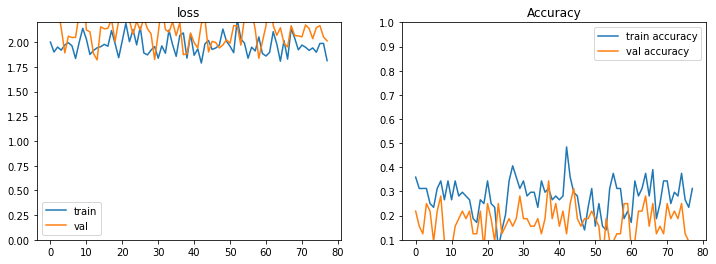

In [ ]:
# learning curves
plot_history(history_vgg, title='', axs=None, exp_name="")

In [ ]:
import seaborn as sns
import matplotlib as mpl
mpl.style.use('seaborn')

fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(model_final.history_vgg.history['accuracy']) + 1), model_final.history_vgg.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(model_final.history_vgg.history['val_accuracy']) + 1), model_final.history_vgg.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Validation Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Validation', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(model_final.history_vgg.history['loss']) + 1), model_final.history_vgg.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(model_final.history_vgg.history['val_loss']) + 1), model_final.history_vgg.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Validation Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Validation', fontsize = 14)
axes[1].legend(loc = 'best')

In [ ]:
plt.plot(history_vgg.history["accuracy"])
plt.plot(history_vgg.history['val_accuracy'])
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

## Evaluating the model

In [ ]:
test_generator = test_datagen.flow_from_directory('data/test/',
                                                  class_mode='categorical',
                                                  batch_size=batch_size)

_, acc = model_final.evaluate(test_generator, steps =100,  verbose=1)

print('> %.3f' % (acc * 100.0))

Found 15804 images belonging to 9 classes.


InvalidArgumentError: ignored

## Model prediction

In [ ]:
yhat = model_final.predict_generator(test_generator, steps=100, verbose=1)